In [1]:
from splink.duckdb.duckdb_linker import DuckDBLinker
import altair as alt
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

## Linking banking transactions

This example shows how to perform a one-to-one link on banking transactions.  The data has the following features:

- Money shows up in the destination account with some time delay
- The amount sent - which we can imagine is sometimes denominated in a foreign currency - and the amount received are not always the same
- The memo is sometimes truncated and content is sometimes missing

Since each origin payment should end up in the destination account, the `probability_two_random_records_match` of the model is known.

In [2]:
# Use arrow to read in data to ensure date types are correct
from pyarrow import parquet as pq
df_origin = pq.read_table("../data/transactions_left.parquet")
df_origin = df_origin.slice(length=1_000)
df_destination = pq.read_table("../data/transactions_right.parquet")
df_destination = df_destination.slice(length=1_000)
f"There are {df_origin.num_rows:,.0f} records to match"

'There are 1,000 records to match'

In [9]:
import duckdb
con = duckdb.connect()
con.register("df", df_origin)
sql = """
select 
memo,

from df_origin
limit 2
"""
con.execute(sql).df()

,memo
0,MATTHIAS C paym
1,M CORVINUS dona


In the following chart, we can see this is a challenging dataset to link:
- There are only 151 distinct transaction dates, with strong skew
- Some 'memos' are used multiple times (up to 48 times)
- There is strong skew in the 'amount' column, with 1,400 transactions of around 60.00

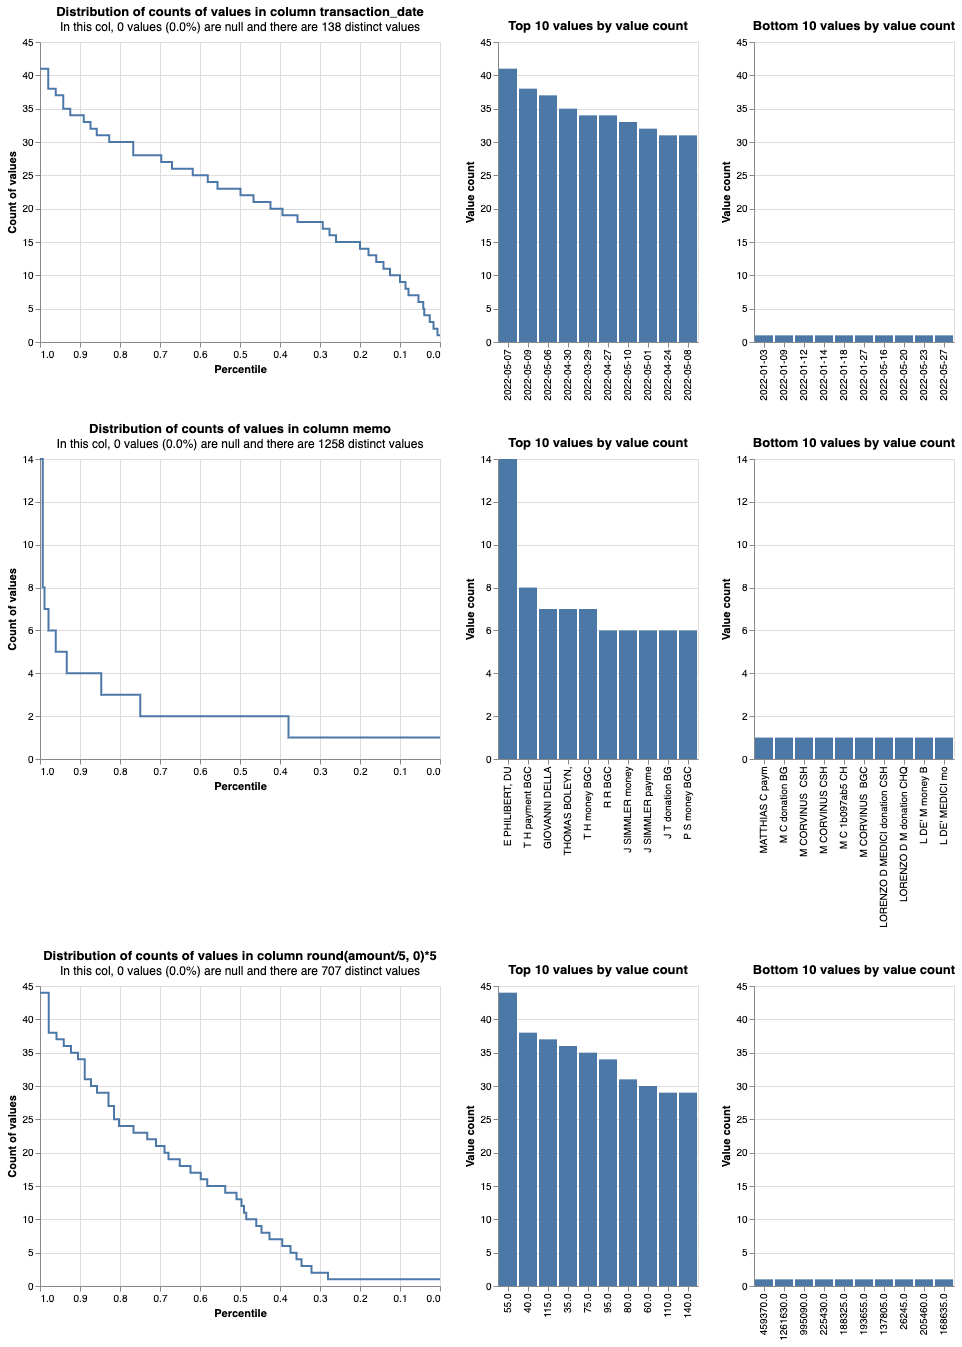

In [4]:
settings = {"link_type": "link_only"}
linker = DuckDBLinker([df_origin, df_destination], settings,input_table_aliases=["__ori", "_dest"])
linker.profile_columns(["transaction_date", "memo", "round(amount/5, 0)*5"])

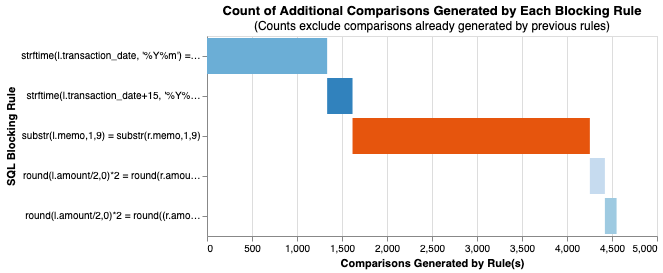

In [5]:
blocking_rule_date_1 = """
    strftime(l.transaction_date, '%Y%m') = strftime(r.transaction_date, '%Y%m')
    and substr(l.memo, 1,3) = substr(r.memo,1,3)
    and l.amount/r.amount > 0.7   and l.amount/r.amount < 1.3
"""

# Offset by half a month to ensure we capture case when the dates are e.g. 31st Jan and 1st Feb
blocking_rule_date_2 = """
    strftime(l.transaction_date+15, '%Y%m') = strftime(r.transaction_date, '%Y%m')
    and substr(l.memo, 1,3) = substr(r.memo,1,3)
    and l.amount/r.amount > 0.7   and l.amount/r.amount < 1.3
"""

blocking_rule_memo = """
substr(l.memo,1,9) = substr(r.memo,1,9)
"""

blocking_rule_amount_1 = """
round(l.amount/2,0)*2 = round(r.amount/2,0)*2 and yearweek(r.transaction_date) = yearweek(l.transaction_date)
"""

blocking_rule_amount_2 = """
round(l.amount/2,0)*2 = round((r.amount+1)/2,0)*2 and yearweek(r.transaction_date) = yearweek(l.transaction_date + 4)
"""

blocking_rule_cheat = """
l.unique_id = r.unique_id
"""


linker.cumulative_num_comparisons_from_blocking_rules_chart(
    [
        blocking_rule_date_1,
        blocking_rule_date_2,
        blocking_rule_memo,
        blocking_rule_amount_1,
        blocking_rule_amount_2,
        blocking_rule_cheat,
    ]
)

In [7]:
import splink.duckdb.duckdb_comparison_level_library as cl

comparison_amount = {
    "output_column_name": "amount",
    "comparison_levels": [
        cl.null_level("amount"),
        cl.exact_match_level("amount"),
        cl.percentage_difference_level("amount",0.01),
        cl.percentage_difference_level("amount",0.03),
        cl.percentage_difference_level("amount",0.1),
        cl.percentage_difference_level("amount",0.3),
        cl.else_level()
    ],
    "comparison_description": "Amount percentage difference",
}

comparison_date = {
    "output_column_name": "transaction_date",
    "comparison_levels": [
        cl.null_level("transaction_date"),
        {"sql_condition": 'transaction_date_r - transaction_date_l <= 1 and transaction_date_r >= transaction_date_l', "label_for_charts": "1 day"},
        {"sql_condition": 'transaction_date_r - transaction_date_l <= 4 and transaction_date_r >= transaction_date_l', "label_for_charts": "<=4 days"},
        {"sql_condition": 'transaction_date_r - transaction_date_l <= 10 and transaction_date_r >= transaction_date_l', "label_for_charts": "<=10 days"},
        {"sql_condition": 'transaction_date_r - transaction_date_l <= 30 and transaction_date_r >= transaction_date_l', "label_for_charts": "<=30 days"},
        cl.else_level("transaction_date")
    ],
    "comparison_description": "Transaction date days apart",
}

comparison_date = {
    "output_column_name": "memo",
    "comparison_levels": [
        cl.null_level("transaction_date"),
        {"sql_condition": 'transaction_date_r - transaction_date_l <= 1 and transaction_date_r >= transaction_date_l', "label_for_charts": "1 day"},

    ],
    "comparison_description": "Transaction date days apart",
}

from splink.duckdb import duckdb_comparison_library as cl

settings = {
    "link_type": "link_only",
    "probability_two_random_records_match": 1 / len(df_origin),
    "blocking_rules_to_generate_predictions": [
        blocking_rule_date_1,
        blocking_rule_date_2,
        blocking_rule_memo,
        blocking_rule_amount_1,
        blocking_rule_amount_2,
        blocking_rule_cheat
    ],
    "comparisons": [
        comparison_amount,
        cl.exact_match(
            "memo"
        ),
        comparison_date
    ],
    "retain_intermediate_calculation_columns": True,
    "retain_matching_columns": True,
}

In [8]:
linker = DuckDBLinker([df_origin, df_destination], settings,input_table_aliases=["__ori", "_dest"])

In [9]:
linker.estimate_u_using_random_sampling(target_rows=1e6)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - amount (no m values are trained).
    - memo (no m values are trained).
    - transaction_date (no m values are trained).


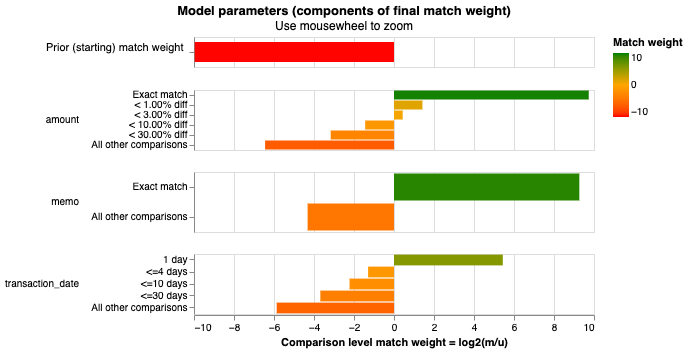

In [10]:
linker.match_weights_chart()

In [11]:
linker.estimate_parameters_using_expectation_maximisation("l.memo = r.memo")


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.memo = r.memo

Parameter estimates will be made for the following comparison(s):
    - amount
    - transaction_date

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - memo

Iteration 1: Largest change in params was -0.557 in the m_probability of amount, level `Exact match`
Iteration 2: Largest change in params was -0.21 in the m_probability of transaction_date, level `1 day`
Iteration 3: Largest change in params was 0.00817 in probability_two_random_records_match
Iteration 4: Largest change in params was -0.000322 in the m_probability of transaction_date, level `1 day`
Iteration 5: Largest change in params was -0.000194 in the m_probability of amount, level `All other comparisons`
Iteration 6: Largest change in params was -0.000173 in the m_probability of amount, level `All other comparisons`
Iteration 7: Largest ch

<EMTrainingSession, blocking on l.memo = r.memo, deactivating comparisons memo>

In [12]:
session = linker.estimate_parameters_using_expectation_maximisation("l.amount = r.amount")


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.amount = r.amount

Parameter estimates will be made for the following comparison(s):
    - memo
    - transaction_date

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - amount

Iteration 1: Largest change in params was 0.316 in probability_two_random_records_match
Iteration 2: Largest change in params was -0.313 in the m_probability of memo, level `Exact match`
Iteration 3: Largest change in params was 0.152 in probability_two_random_records_match
Iteration 4: Largest change in params was 0.026 in probability_two_random_records_match
Iteration 5: Largest change in params was 0.00498 in probability_two_random_records_match
Iteration 6: Largest change in params was 0.001 in probability_two_random_records_match
Iteration 7: Largest change in params was 0.0002 in probability_two_random_records_match
Iteration 8: Largest

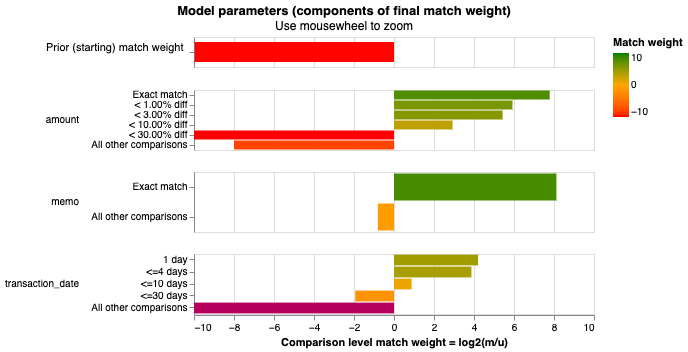

In [13]:
linker.match_weights_chart()

In [14]:
df_predict = linker.predict(threshold_match_probability=0.001)

In [15]:
df_predict.as_pandas_dataframe(limit=10)

,match_weight,match_probability,source_dataset_l,unique_id_l,source_dataset_r,unique_id_r,amount_l,amount_r,gamma_amount,bf_amount,memo_l,memo_r,gamma_memo,bf_memo,transaction_date_l,transaction_date_r,gamma_transaction_date,bf_transaction_date,match_key
0,1.213539,0.698710,__ori,0,_dest,0,36.36,36.36,5,220.345238,MATTHIAS C paym,MATTHIAS C payment BGC,0,0.571559,2022-03-28,2022-03-29,4,18.395523,0
1,-1.143049,0.311675,__ori,13,_dest,13,42.58,43.62,3,43.022940,M C payment,M C BGC,0,0.571559,2022-02-23,2022-02-24,4,18.395523,0
2,0.881471,0.648166,__ori,14,_dest,14,116.93,116.93,5,220.345238,M CORVINUS BGC,M CORVINUS,0,0.571559,2022-03-22,2022-03-24,3,14.613347,0
3,7.784976,0.995486,__ori,17,_dest,17,98.34,96.74,3,43.022940,M C money BGC,M C money BGC,1,278.396949,2022-05-03,2022-05-04,4,18.395523,0
4,7.452908,0.994325,__ori,18,_dest,18,38.23,39.02,3,43.022940,M C BGC,M C BGC,1,278.396949,2022-04-12,2022-04-14,3,14.613347,0
5,-3.976028,0.059750,__ori,31,_dest,31,81.34,77.57,2,7.600650,A F bcc9dd57 BG,A F BGC,0,0.571559,2022-04-20,2022-04-23,3,14.613347,0
6,7.452908,0.994325,__ori,33,_dest,33,174.32,172.06,3,43.022940,A F 22716847 BG,A F 22716847 BG,1,278.396949,2022-03-14,2022-03-16,3,14.613347,0
7,7.452908,0.994325,__ori,35,_dest,35,14073.09,14253.04,3,43.022940,ADRIANO F payme,ADRIANO F payme,1,278.396949,2022-02-07,2022-02-11,3,14.613347,0
8,7.784976,0.995486,__ori,36,_dest,36,1798.25,1823.28,3,43.022940,A F 8a6b4bb8 CH,A F 8a6b4bb8 CH,1,278.396949,2022-02-05,2022-02-06,4,18.395523,0
9,7.452908,0.994325,__ori,37,_dest,37,928.86,903.67,3,43.022940,A F 49c628c0 BG,A F 49c628c0 BG,1,278.396949,2022-05-04,2022-05-06,3,14.613347,0


In [16]:
sql = f"""
select count(*) as num_false_positives, max(match_probability) as max_prob_amongst_false_positives
from {df_predict.physical_name}
where unique_id_l != unique_id_r
and match_probability > 0.5
"""
linker._con.execute(sql).df()

,num_false_positives,max_prob_amongst_false_positives
0,2,0.69871


In [17]:
sql = f"""
select count(*) as num_true_positives
from {df_predict.physical_name}
where unique_id_l == unique_id_r
and match_probability > 0.5
"""
linker._con.execute(sql).df()

,num_true_positives
0,575


In [18]:
f"There were {df_origin.num_rows:,.0f} records to match"

'There were 1,000 records to match'

In [19]:
sql = f"""
select *
from {df_predict.physical_name}
where unique_id_l < 10 and unique_id_l = unique_id_r
order by unique_id_l desc
"""

df_waterfall = linker._con.execute(sql).df().to_dict(orient="records")

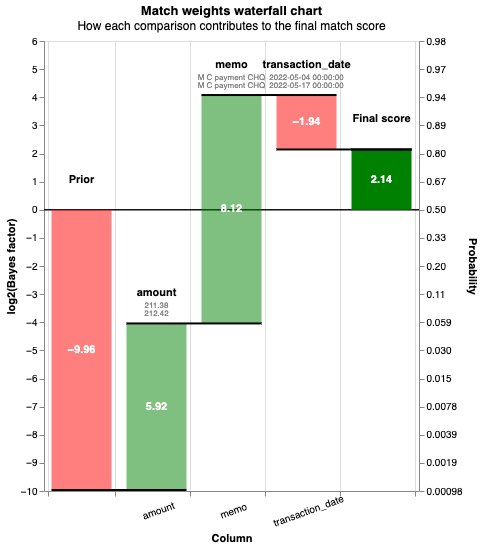

In [20]:
# records_to_view  = df_predict.as_record_dict(limit=5)
linker.waterfall_chart(df_waterfall, filter_nulls=False)

In [21]:
linker.comparison_viewer_dashboard(df_predict,"comparison_viewer_transactions.html")

In [23]:
df_predict.as_pandas_dataframe(limit=2)["transaction_date_l"]

0   2022-03-28
1   2022-02-23
Name: transaction_date_l, dtype: datetime64[ns]

In [34]:
sql = """ select * from __ori limit 2"""
arrow = linker._con.execute(sql).fetch_arrow_table()
arrow.to_pydict()

{'ground_truth': [0, 1],
 'memo': ['MATTHIAS C paym', 'M CORVINUS dona'],
 'transaction_date': [datetime.date(2022, 3, 28), datetime.date(2022, 2, 14)],
 'amount': [36.36, 221.91],
 'unique_id': [0, 1]}